# Twitter Detection Suicide

In [1]:
# Librairies to install
!pip install vaderSentiment
!pip install textblob
!pip install happytransformer
!pip install transformers

In [2]:
# Important librairy
import pandas as pd
import numpy as np
import nltk
import os
import warnings
warnings.filterwarnings('ignore')

# For Modele
from nltk.tag import UnigramTagger
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from happytransformer import HappyTextClassification
from transformers import AutoModel, AutoTokenizer
from transformers import pipeline

# Analyse des données
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# On charge les deux dataset de test et de train
df = pd.read_csv('./Suicide_Detection_Reddit2.csv')
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
24995,A little advise for the boys and girls. (No im...,non-suicide
24996,"When I think of myself, I feel a sickening sen...",suicide
24997,"I’m doneHi guys, new to reddit but need to rea...",suicide
24998,Day three of eating Mac and cheese for lunch c...,non-suicide


In [ ]:
# On affiche la dimension du dataset
print('Nombre de ligne : ' +  str(df.shape[1]))
print('Nombre de colonne : ' + str(df.shape[0]))

# Modeles

# Fonction Globale

In [4]:
# Instanciez le modèle et le tokeniseur
def Classificator(name):
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name)
    return pipeline(model=name)

In [5]:
# Keyword Analyse
train_sents = treebank.tagged_sents()[:3000]
tagger = UnigramTagger(train_sents)

# Classificateur
happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)
classifier_bert = Classificator("nlptown/bert-base-multilingual-uncased-sentiment")
classifier_suicidal_bert = Classificator("gooohjy/suicidal-bert")

01/17/2023 21:55:37 - INFO - happytransformer.happy_transformer -   Using model: cpu
Some weights of the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Some weights of the model checkpoint at gooohjy/suicidal-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

In [6]:
def AddModeleIntoDataframe(df, function_modele, list_column_name):
    df[list_column_name] = df['text'].apply(lambda x: function_modele(x))
    return df

In [7]:
def AddAllModelToDF(df):
    #cleaning du dataframe
    df["text"] = df["text"].apply(lambda x: x[:500])
    
    print("Réalisation de la fonction keyword_analyse en cours ....")
    #df = AddModeleIntoDataframe(df, sentiment_keyword, "keyword_label")
    
    print("Réalisation de la fonction sentiment_vader en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_vader, "valder_label")
    
    print("Réalisation de la fonction sentiment_texblob en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_texblob_polarity, "textbloc_polarity_label")
    df = AddModeleIntoDataframe(df, sentiment_texblob_subjectivity, "textbloc_subjectivity_label")
    
    print("Réalisation de la fonction sentiment_happy_transformer en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_happy_transformer, "happy_transformer_label")
    
    print("Réalisation de la fonction sentiment_bert en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_bert, "bert_label")
    
    print("Réalisation de la fonction sentiment_suicidal_bert en cours ....")
    df = AddModeleIntoDataframe(df, sentiment_suicidal_bert, "suicidal_bert_label")
    
    return df

## KeyWord Analyse

In [8]:
def sentiment_keyword(text):
    texte=word_tokenize(text)
    L=set()
    tag=tagger.tag(texte)

    for t in tag:
        L.add(t[0])

    pos_score=0
    neg_score=0

    for adv in L:
        adv_senti = list(swn.senti_synsets(adv))
        if len(adv_senti)!=0:
            pos_score+=adv_senti[0].pos_score()
            neg_score+=adv_senti[0].neg_score()
    res=''
    
    if pos_score > neg_score:
        res='pos'
    elif pos_score < neg_score:
        res='neg'

    return res,pos_score,neg_score

## Valder

In [9]:
def sentiment_vader(sentence):
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"
        
    elif sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"   

    else :
        overall_sentiment = "Neutral"
  
    return overall_sentiment

## TextBlob

In [10]:
def sentiment_texblob_polarity(row):
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    return polarity

def sentiment_texblob_subjectivity(row):
    classifier = TextBlob(row)
    subjectivity = classifier.sentiment.subjectivity
    return subjectivity

## Happy Transformer

In [11]:
def sentiment_happy_transformer(row):
    result = happy_tc.classify_text(row)
    return str(result.label)

## BERT

In [12]:
def sentiment_bert(row):
    # On recupere le sentiment
    res = classifier_bert(row)

    # Ajoutez les résultats aux tableaux
    return res[0]['label'][:1]

## Suicidal BERT

In [13]:
def sentiment_suicidal_bert(row):
    # On recupere le sentiment
    res = classifier_suicidal_bert(row)

    # Ajoutez les résultats aux tableaux
    return res[0]['label']

# Analyse

In [14]:
def PreparationModel(df):
    df["class"] = df["class"].replace({"suicide": 1, "non-suicide": 0})
    df["valder_label"] = df["valder_label"].replace({"Negative": 1, "Positive": 0, "Neutral": 0})
    df["happy_transformer_label"] = df["happy_transformer_label"].replace({"NEGATIVE": 1, "POSITIVE": 0})
    df["bert_label"] = df["bert_label"].replace({"1": 1, "2": 0, "3": 0, "4": 0, "5": 0})
    df["suicidal_bert_label"] = df["suicidal_bert_label"].replace({"LABEL_1": 1, "LABEL_0": 0})
    return df

In [15]:
df = AddAllModelToDF(df)
df = PreparationModel(df)
df

Réalisation de la fonction keyword_analyse en cours ....
Réalisation de la fonction sentiment_vader en cours ....
Réalisation de la fonction sentiment_texblob en cours ....
Réalisation de la fonction sentiment_happy_transformer en cours ....
Réalisation de la fonction sentiment_bert en cours ....
Réalisation de la fonction sentiment_suicidal_bert en cours ....


,text,class,valder_label,textbloc_polarity_label,textbloc_subjectivity_label,happy_transformer_label,bert_label,suicidal_bert_label
0,Ex Wife Threatening SuicideRecently I left my ...,1,1,0.080000,0.140000,1,1,1
1,Am I weird I don't get affected by compliments...,0,0,0.100000,0.800000,0,0,0
2,Finally 2020 is almost over... So I can never ...,0,1,-0.525000,0.841667,1,1,0
3,i need helpjust help me im crying so hard,1,1,-0.245833,0.570833,1,0,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1,1,-0.109722,0.653704,1,0,1
...,...,...,...,...,...,...,...,...
24995,A little advise for the boys and girls. (No im...,0,0,-0.029167,0.466667,0,0,0
24996,"When I think of myself, I feel a sickening sen...",1,1,0.133274,0.622063,1,0,1
24997,"I’m doneHi guys, new to reddit but need to rea...",1,1,0.038300,0.376431,1,0,1
24998,Day three of eating Mac and cheese for lunch c...,0,1,-0.032955,0.681818,1,0,0


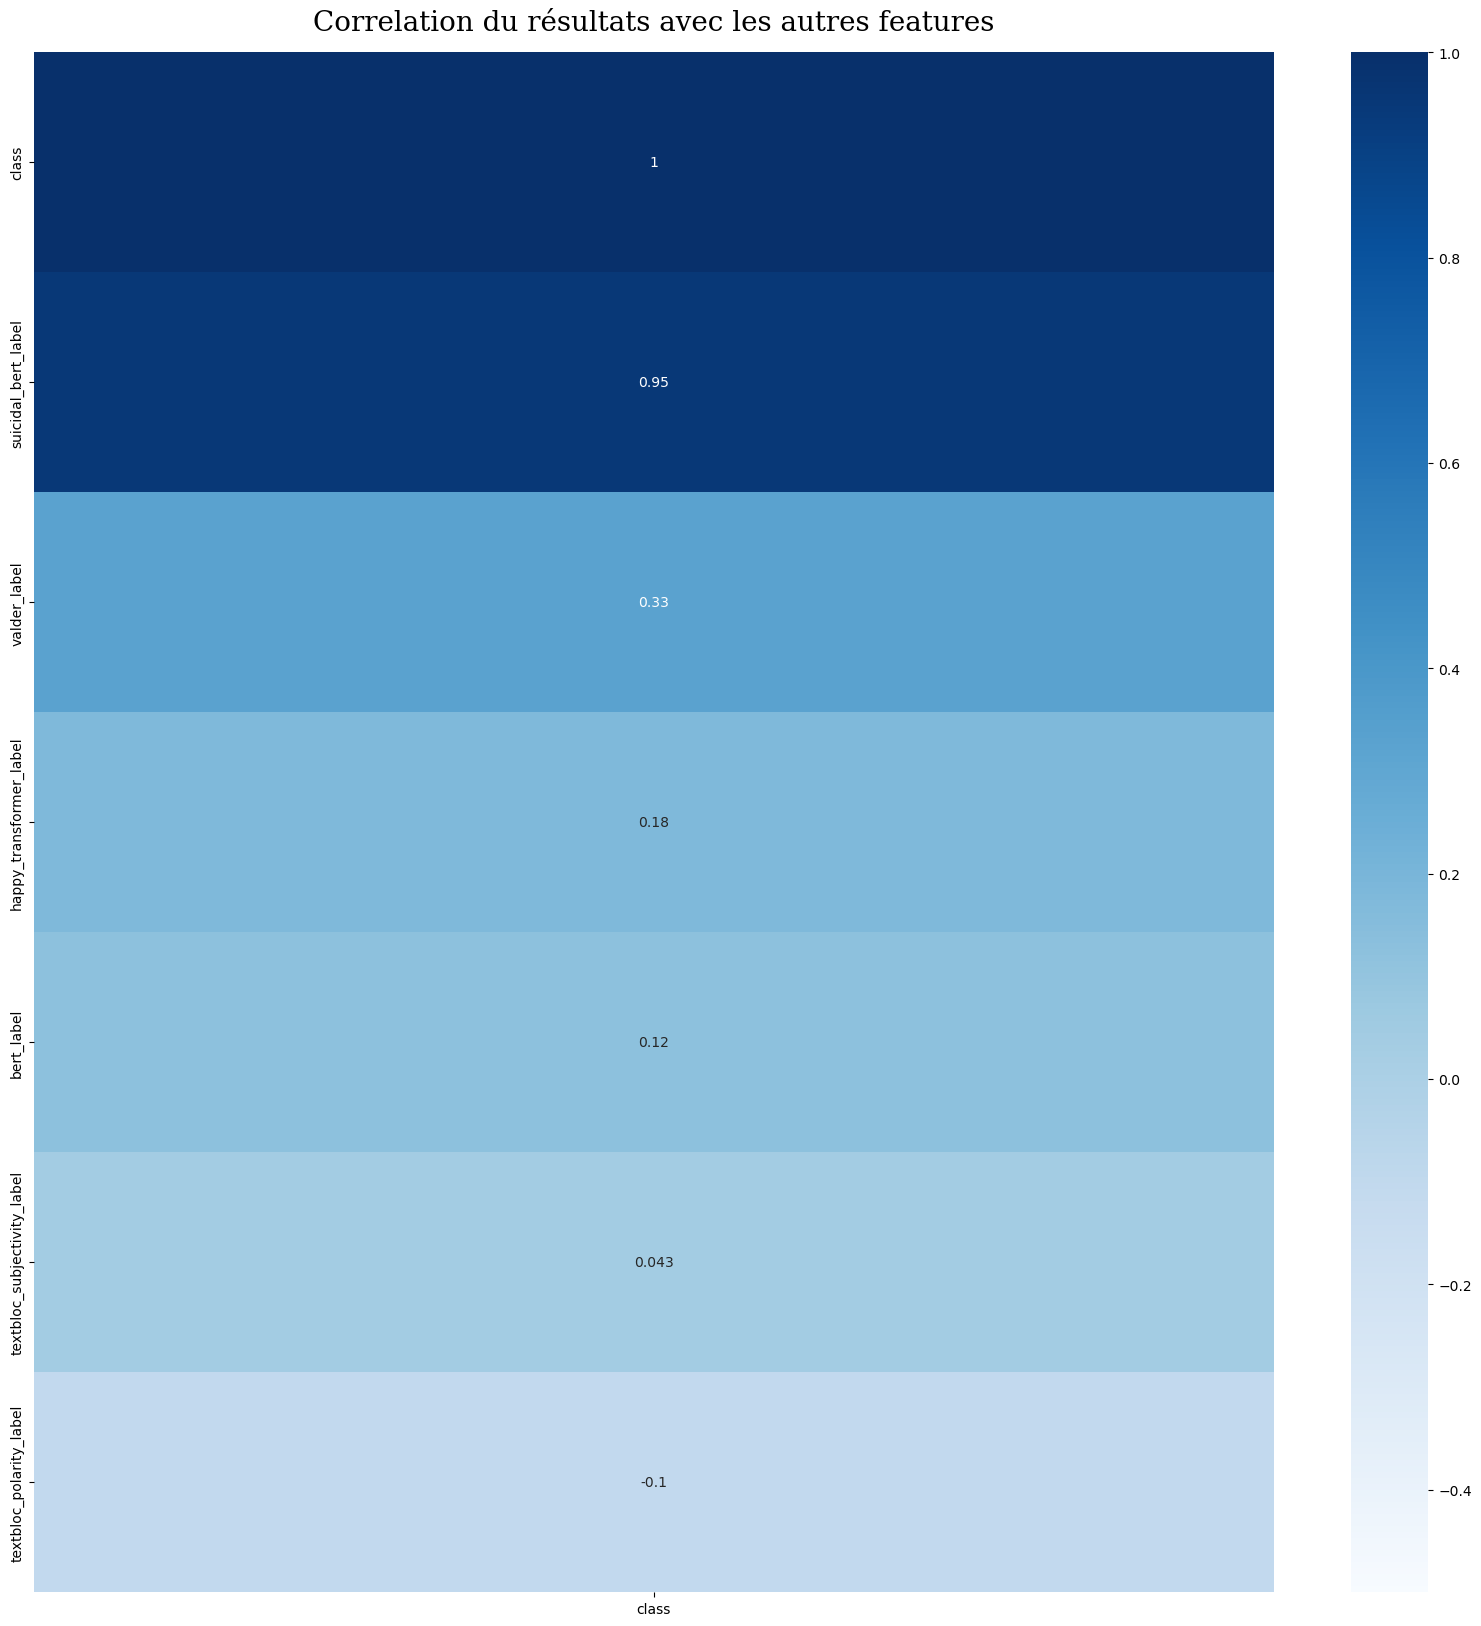

In [16]:
# Nous allons nous concentrez uniquement sur la caractéristique cible
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(df.corr()[['class']].sort_values(by='class', ascending=False), vmin=-0.5, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation du résultats avec les autres features', pad=16, fontdict={'family': 'serif','size': 20});

In [17]:
df.to_csv('./Suicide_Detection_Reddit_Final.csv', index=False)

# Prediction

In [7]:
df = pd.read_csv('./Suicide_Detection_Reddit_Final.csv')

In [8]:
def TauxBonneReponse(df):
    # Sélection des lignes où la colonne "class" contient la valeur 1
    selected_true_positive = df.loc[df['class'] == 1]
    return [selected_true_positive.shape[0], df.shape[0], round(selected_true_positive.shape[0] / df.shape[0], 2)]

In [9]:
# Genere un dataframe ou stock le meilleur modele pour chaque méthode
ResultDf = pd.DataFrame()
def StockResultDf(name, df):
    global ResultDf
    tab = TauxBonneReponse(df)
    listValue = {'Methode Name': name, 'Nombre de bonne reponse': tab[0], 'Nombre de réponse totale': tab[1] , 'Taux de bonne réponse (%)': tab[2]}
    ResultDf = ResultDf.append(listValue,ignore_index=True)

In [10]:
def SelectionTweetSuicidaire(df):
    #Methode Naif
    StockResultDf("Naif", df)
    
    #Methode 1
    # On ne garde que suicidal bert
    df1 = df[df['suicidal_bert_label'] == 1]
    StockResultDf("Model 1", df1)
    
    #Methode 2
    # Sélection des lignes où au moins 3 des colonnes ont la valeur 1
    df2 = df[(df[['valder_label', 'happy_transformer_label', 'bert_label', 'suicidal_bert_label']].sum(axis=1) >= 3)]
    StockResultDf("Model 2", df2)
    
#On execute puis on affiche le resultat
SelectionTweetSuicidaire(df.copy())
ResultDf

,Methode Name,Nombre de bonne reponse,Nombre de réponse totale,Taux de bonne réponse (%)
0,Naif,12386,25000,0.50
1,Model 1,11950,12125,0.99
2,Model 2,9488,12334,0.77
